In [1]:
import os
print(os.getcwd())

# from eals_radcliff.utils import dataframes, radcliff_utils, config
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action="ignore")

from scipy.stats import pearsonr
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import utils

# Config
sns.set_context('notebook', font_scale=1.3)

/home/ubuntu/git/audio/gaston/radcliff/ReliableMonitoringRPFTALS


## Functions

In [2]:
def plot_user_traj(
    data,
    pat_id,
    var,
    time_col="days_since_first_session",
    var_error=None,
    hue_query_fit=None,
    hue_names_fit=None,
    hue_query_plot=None,
    hue_names_plot=None,
    plot_all_efforts=False,
    ax=None,
    title=None,
    figsize=(5, 3),
    do_legend=False,
    legend_loc=(0.5, 0.5),
    fs=12,
    ylabel=None,
    xlabel=None,
    fill_between=True,
    plot_regression_line=True,
    extend_regression=False,
    alpha=[0.9, 0.9],  # [0.7, 0.85],
    marker=["o", "+"],
    size=[50, 140],
    color_1="blue",
    color_2="green",
    color_3="red",
    color_4="red",
    alpha_lr=1,
    **kwargs,
):
    """
    Plot user trajectory for a specific variable.

    Parameters:
    - data: DataFrame containing the data.
    - pat_id: Patient ID.
    - var: Variable to plot.
    - var_error: Error variable (optional).
    - hue_query: Query for hue levels (optional).
    - hue_names: Names for hue levels (optional).
    - plot_all_efforts: Whether to plot all efforts (optional).
    - time_col: time unit column to use (days, months, years).
    - ax: Axes object to plot on (optional).
    - title: Title of the plot (optional).
    - figsize: Figure size (optional).
    - do_legend: Whether to show the legend (optional).
    - fs: Font size (optional).
    - **kwargs: Additional keyword arguments for plotting.

    Returns:
    - DataFrame: DataFrame containing all efforts.
    """
    try:
        if var.startswith("fvc"):
            # esto para las distintas variantes de 'fvc' como percpred o 2019
            df1 = data.query('subject_id == @pat_id and pftType=="fvc"').copy()
        elif var.startswith("vc"):
            df1 = data.query('subject_id == @pat_id and pftType=="svc"').copy()
        else:
            df1 = data.query("subject_id == @pat_id").copy()

        assert time_col in df1.columns, f"ERROR: {time_col} column not found"

        if var == "svc":
            # SVC se llama en realidad vc en el dataframe pero el pftType es svc
            var = "vc"
        # Drop NaNs in the variable column and corresponding dates
        df1 = df1.dropna(subset=[var, time_col])
    except KeyError:
        print(f"Patient with no {var.upper()}")
        return

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)

    # Main curve
    if hue_query_plot is not None:
        q1_plot, q2_plot = hue_query_plot
        if q1_plot is None and q2_plot is not None:
            df_plot = df1.query(f"{q2_plot}")
        elif q1_plot is not None and q2_plot is None:
            df_plot = df1.query(f"{q1_plot}")
        else:
            df_plot = df1.copy()
    else:
        df_plot = df1.copy()

    if var_error is not None:
        ax.fill_between(
            df_plot[time_col].values,
            df_plot[var].values - df_plot[var_error].values,
            df_plot[var].values + df_plot[var_error].values,
            color="gray",
            alpha=0.2,
        )

    if not plot_all_efforts:

        if hue_query_fit is None:
            l1_fit = hue_names_fit
            x1_fit = df1[time_col].values
            y1_fit = df1[var].values
        else:
            q1_fit, _ = hue_query_fit
            x1_fit = df1.query(q1_fit)[time_col].values
            y1_fit = df1.query(q1_fit)[var].values

        if hue_query_plot is None:
            l1_plot = hue_names_plot
            x1_plot = df1[time_col].values
            y1_plot = df1[var].values
        else:
            q1_plot, q2_plot = hue_query_plot
            l1_plot, l2_plot = hue_names_plot
            x1_plot = df1.query(q1_plot)[time_col].values
            y1_plot = df1.query(q1_plot)[var].values
            if q2_plot is not None:
                x2_plot = df1.query(q2_plot)[time_col].values
                y2_plot = df1.query(q2_plot)[var].values

        # Plot good quality points
        ax.scatter(
            x1_plot,
            y1_plot,
            color=color_2,
            marker=marker[0],
            alpha=alpha[0],
            # facecolors="none",
            label=l1_plot,
            s=size[0],
        )

        # Regression Line
        if len(x1_fit) < 3 or len(y1_fit) < 3:
            p_value = np.nan
        else:
            (
                y_pred,
                lower_bound,
                upper_bound,
                p_value,
                slope,
                _,
                intercept,
                _,
            ) = utils.fit_regression(x1_fit, y1_fit, output_all=True)
            if extend_regression:
                # Extend backwards
                x1_fit = np.append(x1_fit, 0)
                y_pred = np.append(y_pred, intercept)

                # Extend forward
                x1_fit = np.append(x1_fit, 15)
                y_pred = np.append(y_pred, 15 * slope + intercept)

            if plot_regression_line:
                ax.plot(
                    x1_fit,
                    y_pred,
                    color=color_4,
                    alpha=alpha_lr,
                    linewidth=2,
                    label=None,
                )
                if fill_between:
                    ax.fill_between(
                        x1_fit, lower_bound, upper_bound, color="lightgrey", alpha=0.2
                    )

        # Plot bad quality points
        if hue_query_plot is not None:
            if q2_plot is not None:
                ax.scatter(
                    x2_plot,
                    y2_plot,
                    color=color_3,
                    marker=marker[-1],
                    alpha=alpha[-1],
                    # facecolors="none",
                    facecolors="white",
                    label=l2_plot,
                    s=size[-1],
                )

        if do_legend:
            ax.legend(loc=(legend_loc))

    ax.set_xlabel(
        xlabel,
        fontdict={"fontsize": fs},
    )
    
    ax.set_yticks([0, 50, 100, 150])
    ax.set_yticklabels([0, 50, 100, 150])
    
    if ylabel is None:
        ylabel = var.upper()
    ax.set_ylabel(ylabel, fontdict={"fontsize": fs})
    if time_col == "date_only":
        ax.tick_params(axis="x", rotation=45)
    ax.tick_params(axis="both", which="major", labelsize=fs)
    ax.tick_params(axis="both", which="minor", labelsize=fs)

    if title is not None:
        ax.set_title(title, fontdict={"fontsize": fs})
    else:
        ax.set_title(f"subject_id: {pat_id[:8]}", fontdict={"fontsize": fs})
    ax.grid(True)

    if ax is None:
        plt.show()
    if do_legend:
        ax.legend(loc=(legend_loc))


In [3]:
def plot_figure3_figsupp3(
    data: pd.DataFrame,
    pat_list: list,
    data_dict: list,
    time_col="days_since_first_session",
    **kwargs,
):
    # FIXED VARS
    figsize=(12, 5)
    ylim = (-0.0, 150)
    xlim = (0, 16)
    mute_titles= True
    mute_right_ticks= True
    mute_x_ticks= True
    plot_regression_line= True,
    extend_regression= False
    fill_between= False
    fs = 14
    label_y={'fvcPercPred_2019': 'FVC % predicted', 'vcPercPred': 'SVC % predicted'}
    xlabel='Months since enrollment'
    df = data.copy()
    ################
    n_cols = 2
    n_rows = 4
    
    # Creating the shared subplots (occupying the left half)
    fig = plt.figure(figsize=figsize, layout='constrained')
    gs = GridSpec(n_cols, n_rows, figure=fig, width_ratios=[1.5,1.5,1,1])
    
    # Create the subplots dynamically
    axs = [
            fig.add_subplot(gs[0, 0]), 
            fig.add_subplot(gs[0, 1]),
            fig.add_subplot(gs[1, 0]), 
            fig.add_subplot(gs[1, 1])
        ]
    
        
    for i, pat in enumerate(pat_list):
        for i2, value in enumerate(data_dict):
            key = value["var_name"]
            list_of_kwargs = [
                "hue_query_fit",
                "hue_names_fit",
                "hue_query_plot",
                "hue_names_plot",
                "alpha",
                "marker",
                "size",
                "do_legend",
                "legend_loc",
                "color_1",
                "color_2",
                "color_3",
                "color_4",
                "alpha_lr",
            ]
            for l in list_of_kwargs:
                if l in value.keys():
                    kwargs.update({l: value[l]})
            if i != 1:
                kwargs.update({'do_legend': False})
            if i2 > 0:
                # Quitar ticks para el segundo eje
                axs[i] = axs[i].twinx()
                if mute_right_ticks:
                    axs[i].set_yticks([])
            
            a = plot_user_traj(
                df,
                pat,
                key,
                time_col=time_col,
                fill_between=fill_between,
                plot_regression_line=plot_regression_line,
                extend_regression=extend_regression,
                ax=axs[i],
                **kwargs,
            )

            axs[i].set_xticks(range(0,20,4))
            
            if mute_x_ticks:
                axs[i].set_xlabel("")

            # Clean Y labels and ticks
            if i2 > 0:
                if (i + 1) % n_cols != 0:
                    axs[i].set_ylabel("")
                else:
                    try:
                        axs[i].set_ylabel(label_y[key])
                    except KeyError:
                        axs[i].set_ylabel(key)
            else:
                axs[i].tick_params(labelleft=False) 
                axs[i].set_ylabel("")

            if mute_titles:
                axs[i].set_title("")

            # set xlims y ylims
            if ylim is not None:
                if isinstance(ylim, list):
                    axs[i].set_ylim(ylim[i2])
                else:
                    axs[i].set_ylim(ylim)
            if xlim is not None:
                axs[i].set_xlim(xlim)
                
            # add patient id
            pat = df[df['subject_id'] == pat]['subject_order'].values[0]
            axs[i].text(0.05, 0.05, pat, fontsize=fs, transform=axs[i].transAxes, ha='left', va='bottom')
    
    fig.text(.29, -.025, xlabel, ha='center', va='center', fontsize=20)
    fig.text(-.025, 0.5, 'FVC % predicted', ha='center', va='center', rotation='vertical', fontsize=20)
    
    #######################
    #VALIDATE
    single_ax = fig.add_subplot(gs[:, 2:]) 
        
    def rmse(group):
        return np.sqrt(np.mean((group['fvcPercPred_2019'] - group['y_pred_fvcPercPred_2019']) ** 2))
    rmse_by_subject = df.groupby(['subject_id', 'is_proctored']).apply(rmse).reset_index(name='RMSE')
    rmse_by_subject['is_proctored_str'] = ['Proctored' if x else 'Non-proctored' for x in rmse_by_subject['is_proctored'].values]
    
    col1 = 'is_proctored_str'
    col2 = 'RMSE'

    # aux = rmse_by_subject[['subject_id', col1, col2]].drop_duplicates()
    aux = rmse_by_subject[['subject_id', col1, col2]].copy()
    print(f"Total of subjets: {len(aux)/2}")
    
    # Conduct t-test
    try:
        group1 = aux[aux[col1] == 'Proctored'][col2]
        group2 = aux[aux[col1] == 'Non-proctored'][col2]
        t_stat, p_value = stats.ttest_rel(group1, group2, nan_policy='omit')
    except Exception as e:
        print(e)
    
    palette = sns.color_palette("colorblind").as_hex()[:2]
    # map palette to is_proctored_str
    palette = dict(zip(aux[col1].unique()[::-1], palette))
    print(palette)
    aux.sort_values(by=col1, ascending = False, inplace=True)
    sns.boxplot(ax=single_ax, 
                x=col1,
                y=col2,
                fliersize=0,
                data=aux,
                palette = {'Proctored': 'white', 'Non-proctored': 'white'},)# palette=["#d1d0de","#5d6e9e"])

    # Aplicar alpha a un boxplot específico
    for i, artist in enumerate(single_ax.artists):  # Iterar sobre los boxplots
        if i == 1:  # Cambiar alpha para el primer boxplot (ajustar según tu caso)
            artist.set_alpha(0.5)

    sns.swarmplot(ax=single_ax, 
                  x=col1, 
                  y=col2, 
                  data=aux,
                  palette ={'Proctored': palette['Proctored'], 'Non-proctored': 'white'},
                  edgecolor = palette['Proctored'],
                  size=6, 
                  linewidth=1.2,)# edgecolor='0.25')

    # Customize plot
    single_ax.set_xlabel(None)
    single_ax.tick_params(axis='x', labelsize=20)  
    single_ax.set_ylabel('RMSE FVC % predicted', fontsize=20)
    single_ax.tick_params(axis='y', labelsize=12)
    single_ax.set_yticks(range(0, 17, 4))
    single_ax.set_ylim(-1, 18)
    single_ax.spines["top"].set_color("black")
    single_ax.spines["right"].set_color("black")
    single_ax.spines["bottom"].set_color("black")
    single_ax.spines["left"].set_color("black")

    # Add t-test result line and asterisk
    if p_value < 0.05:
        # Get the positions for the annotation
        y_max = max(aux[col2])
        x1, x2 = 0, 1  # positions for the two boxplots
        y, h, col = y_max + 0.5, 0.3, 'k'

        single_ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        single_ax.text((x1 + x2) * 0.5, y + h, '*', ha='center', va='bottom', color=col, fontsize=20)

    # Print t-test result
    print(f"T-statistic: {t_stat}, P-value: {p_value}")
    print(f"N subjects: {aux.subject_id.nunique()}")
    
    #######################
    # Format 
    # letters with automatic positioning
    axs[0].text(0.00, 1.35, 'a', fontsize=30, transform=axs[0].transAxes, va='top', ha='left')
    single_ax.text(0.00, 1.15, 'b', fontsize=30, transform=single_ax.transAxes, va='top', ha='left')
    
    plt.show()
    
    return rmse_by_subject # para debug

## Data

In [4]:
PATH = 'data'
FILE = 'data_fig3.csv'
df_data = pd.read_csv(os.path.join(PATH,FILE))

# Keep only FVC
df_data = df_data.query('pftType=="fvc"')

# Keep only those with at least one of each
subs = df_data.groupby('subject_id').apply(lambda s: s.is_proctored.nunique()==2)
subs = subs[subs].index
df_data = df_data.query('subject_id in @subs')

print(f'N subjects: {df_data.subject_id.nunique()}')
print(f"N proctored sessions: {df_data.query('is_proctored==True').session_id.nunique()}")
print(f"N non-proctored sessions: {df_data.query('is_proctored==False').session_id.nunique()}")
print(f"N sessions: {df_data.session_id.nunique()}")

N subjects: 23
N proctored sessions: 284
N non-proctored sessions: 173
N sessions: 457


## Figure

In [5]:
patient_sorted = [
    
    'b323b082-0ca4-4b58-b899-3e87e41074fb',
    '095b55de-6600-4d17-b8e6-387a7ef9db6f',
    'fc3f4670-6329-4886-868e-81eb8f8f7ba3',
    '9941063b-9b74-4eb0-b24f-b73cb9324ee5'   
]

colors = sns.color_palette("colorblind").as_hex()

data_dict_fvc = [
    
    {'var_name': 'fvcPercPred_2019',
    'hue_query_fit': None,
    'hue_names_fit':  [None, None],
    'hue_query_plot': [ 
        'is_proctored', 'not is_proctored'
    ],
    'hue_names_plot': ["Proctored", "Non-proctored"],
    'alpha': [1, 1],
    'marker':['o'],
    'size':[50, 50],
    'do_legend': True,
    'legend_loc':(.31,.6),
    'color_1': 'red',
    'color_2': colors[0], #'red', #'#5d6e9e',
    'color_3': colors[0], #'red', #d1d0de',
    'color_4': 'black',
    'alpha_lr':0.7,
    }
]


Total of subjets: 23.0
{'Proctored': '#0173b2', 'Non-proctored': '#de8f05'}
T-statistic: -0.3961183827434985, P-value: 0.6958333870814588
N subjects: 23


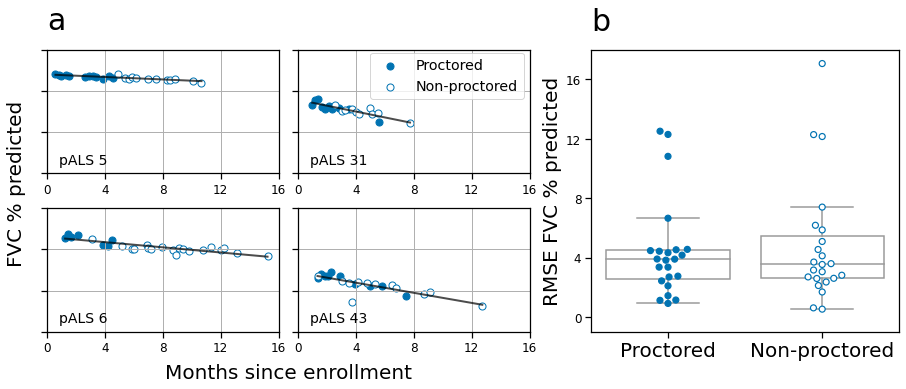

In [6]:
r = plot_figure3_figsupp3(
    df_data, 
    patient_sorted,
    data_dict_fvc,
    time_col="months_since_first_session",
)